Defining   an    "adopted   user"   as   a   user   who has   logged   into   the   product   on   three   separatedays   in   at   least   one   seven­day   period ,   identify   which   factors   predict   future   useradoption .

In [1]:
pwd 

'/Users/andrewstephens/Springboard/relax_challenge'

In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix,plot_roc_curve
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [3]:
#read in csv files as pandas dataframes
users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
#convert timestamp to datetime 

engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [9]:
usage = engagement.groupby(['user_id']).size().reset_index().rename(columns={0:'count'})

In [10]:
usage['adopted'] = usage['count']>=3

In [11]:
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [12]:
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

In [13]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [14]:
users_clean = users.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')

In [15]:
users_clean.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [16]:
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [17]:
#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)


In [18]:
#Convert creation_time and last_session_creation_time to datetime
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

In [19]:
#Extract months from datetime columns.
df['creation_month'] = df.creation_time.dt.month

df['last_session_creation_month'] = df.last_session_creation_time.dt.month

In [20]:
#convert invited by user_id to boolean
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [21]:
#drop redundant columns that have been converted to features
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   opted_in_to_mailing_list     12000 non-null  int64  
 1   enabled_for_marketing_drip   12000 non-null  int64  
 2   org_id                       12000 non-null  int64  
 3   adopted                      12000 non-null  int64  
 4   ORG_INVITE                   12000 non-null  uint8  
 5   PERSONAL_PROJECTS            12000 non-null  uint8  
 6   SIGNUP                       12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH           12000 non-null  uint8  
 8   creation_month               12000 non-null  int64  
 9   last_session_creation_month  8823 non-null   float64
 10  invited                      12000 non-null  int64  
dtypes: float64(1), int64(6), uint8(4)
memory usage: 796.9 KB


In [23]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

18.7 % of observed users were adopted


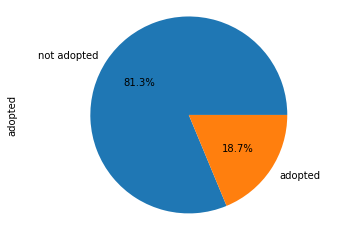

In [24]:
print(format(df.adopted.sum()/df.adopted.count()*100,'1.1f'), '% of observed users were adopted')
f = df.adopted.value_counts().plot(kind='pie',labels=['not adopted','adopted'],autopct='%1.1f%%')
f = plt.axis('equal')



In [25]:
#Splitting data 

X = df.drop(['adopted'],axis=1)
y = df['adopted']

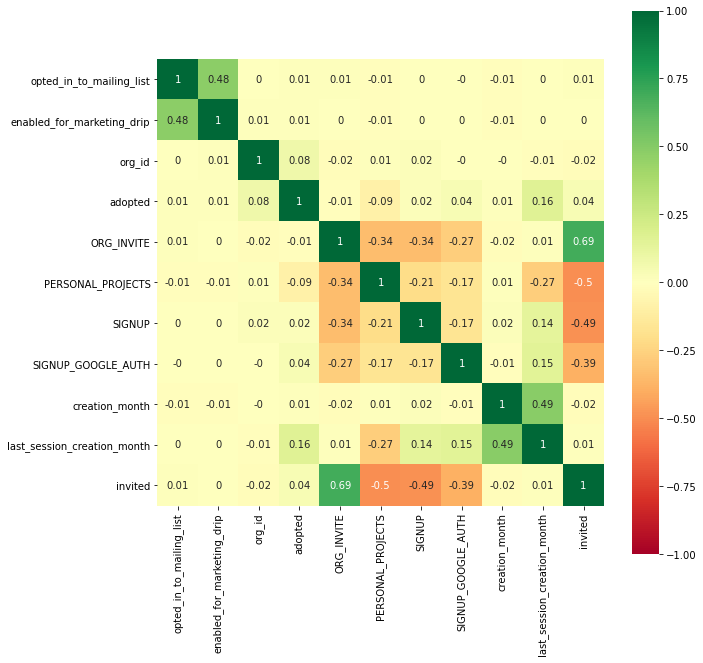

In [26]:
#heatmap 
plt.figure(figsize=(10,10))
d = sns.heatmap(df.corr().round(2),square = True,annot=True,cmap='RdYlGn',vmin=-1,vmax=1)

The correlation matrix shows that last_session creation_month has the strongest direct, linear correation with adopted (0.16). None of the other columns have a correlation factor greater than 0.7 so no multicollinearity is evident from this matrix. We will not look at the variance inflation factors to confirm.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='adopted', ylabel='count'>

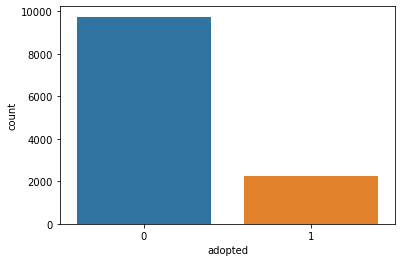

In [27]:
sns.countplot(y)

data set is inbalanced and will need to be oversampled. 

# Model 

In [28]:
# summarize class distribution

print("Before oversampling: ", Counter(y))

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)



# fit and apply the transform
X, y = oversample.fit_resample(X, y)


# summarize class distribution

print("After oversampling: ", Counter(y))

Before oversampling:  Counter({0: 9752, 1: 2248})
After oversampling:  Counter({0: 9752, 1: 9752})


In [29]:
#splitting into test/train sets 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1)

In [33]:
# instantiate model 
rf = RandomForestClassifier(random_state=1)

#Cross-validate on training set, using f1 score because binary classification. 
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='accuracy')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

In [34]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))

Train Accuracy: 0.94706
Test Accuracy: 0.94796


Confusion matrix, without normalization
[[1894   91]
 [ 112 1804]]
Normalized confusion matrix
[[0.95415617 0.04584383]
 [0.05845511 0.94154489]]


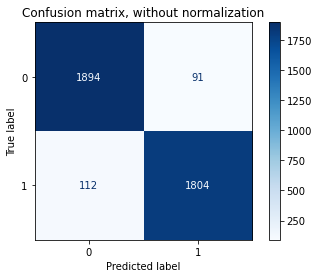

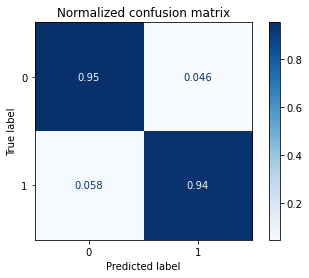

In [38]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


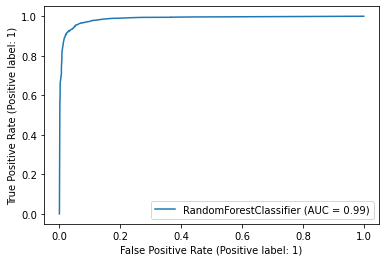

In [40]:
rf_roc = plot_roc_curve(rf, X_test, y_test)

<AxesSubplot:>

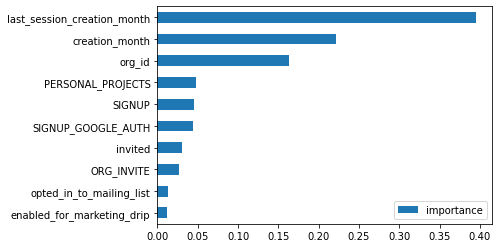

In [41]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

Based on the feature importance plot, we can see that the last_session_creation_month is the most important feature, followed by the creation_month. We can perform some EDA in order to better understand how the last_session_creation_month is correlated to adoption.

<AxesSubplot:xlabel='last_session_creation_month'>

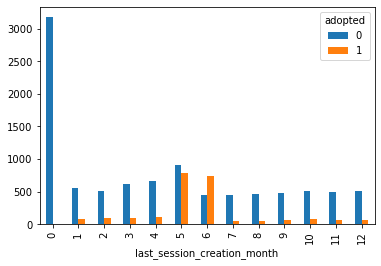

In [42]:
pd.crosstab(df.last_session_creation_month,df.adopted).plot(kind='bar')

We can see that, obviously, users who have not logged in within the past 2 years will not be considered adopted users and there are a significant number of users who have not logged in within the last 2 years. We would want to perform further analysis on this subset of users to better understand why they have not logged in. Most adopted users last logged in in May and June so I would want to understand what was done in May and June (any special deals etc.) that could have led to better user retention.